# Install repository and requirements

In [2]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.0 MB/s eta 0:00:00


# Importing dependencies

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import wandb
wandb.init(project="mnist-gans", name="dcgan")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Data Loading

## Download and normalize to range [-1, 1]

In [4]:
dataset_train = torchvision.datasets.FashionMNIST('./train', train=True, download=True,
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

100%|██████████| 26421880/26421880 [00:05<00:00, 4748982.13it/s]


Extracting ./train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./train/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 199398.37it/s]


Extracting ./train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3764524.72it/s]


Extracting ./train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./train/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4051083.86it/s]

Extracting ./train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw



In [5]:
dataset_test = torchvision.datasets.FashionMNIST('./test', train=False, download=True,
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

100%|██████████| 26421880/26421880 [00:02<00:00, 12769707.64it/s]


Extracting ./test/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./test/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 197130.95it/s]


Extracting ./test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./test/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3783348.72it/s]


Extracting ./test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./test/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3418122.05it/s]

Extracting ./test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/FashionMNIST/raw



In [6]:
# Change labels of dataset to real
dataset_train.targets = torch.ones(len(dataset_train))
dataset_test.targets = torch.ones(len(dataset_test))

In [7]:
labels_map = {0: 'Fake', 1: 'Real'}

## Concatenating train and test dataset

In [8]:
dataset = dataset_train + dataset_test
print(f'Length of complete dataset : {len(dataset)}')

Length of complete dataset : 70000


## Initializing constants

In [9]:
torch.cuda.is_available()

True

In [10]:
params = {}
params['epochs'] = 80
params['output_after_every_n_epochs'] = 1
params['image_size'] = 28
params['noise_size'] = 100
params['batch_size'] = 64
params['num_channels'] = 1
params['seed'] = 0
wandb.config.update(params)

In [11]:
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [12]:
# Note: PyTorch does not guarantee reproducability
# Taken from https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(params['seed'])

## Convert into DataLoader

In [13]:
datasetloader = torch.utils.data.DataLoader(dataset_train, batch_size=params['batch_size'], shuffle=True)

In [14]:
# This is just for visualization and a little debugging
dataiter = iter(datasetloader)

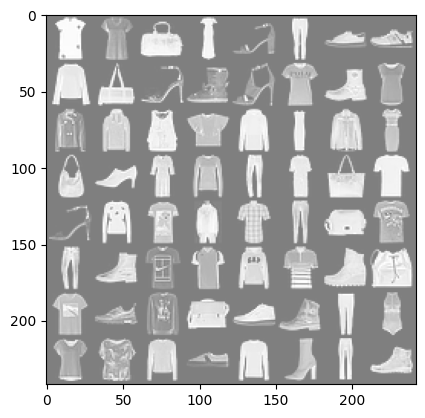

In [15]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming dataset_train and params are already defined
datasetloader = torch.utils.data.DataLoader(dataset_train, batch_size=params['batch_size'], shuffle=True)

# Create an iterator over the dataset
dataiter = iter(datasetloader)

# Get the next batch of images and labels
images, labels = next(dataiter)

# Function to show the grid of images
def show_grid(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show the grid of images
show_grid(torchvision.utils.make_grid(images, normalize=True))


# Initialize Weights

In [16]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [17]:
class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, num_channels):
        super(Generator, self).__init__()

        self.conv_trans_1 = nn.Sequential(
            nn.ConvTranspose2d(noise_size, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        # Shape [2 x 2]

        self.conv_trans_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        # Shape [4 x 4]

        self.conv_trans_3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        # Shape [7 x 7]

        self.conv_trans_4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        # Shape [14 x 14]

        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(64, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        # Shape [28 x 28]

        self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def forward(self, inputs):
        x = self.conv_trans_1(inputs)
        x = self.conv_trans_2(x)
        x = self.conv_trans_3(x)
        x = self.conv_trans_4(x)
        return self.output_layer(x)

In [18]:
generator = Generator(params['noise_size'], params['num_channels'])
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (conv_trans_1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_trans_2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_trans_3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_trans_4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (outp

## Test output shape of Generator

torch.Size([64, 1, 28, 28])


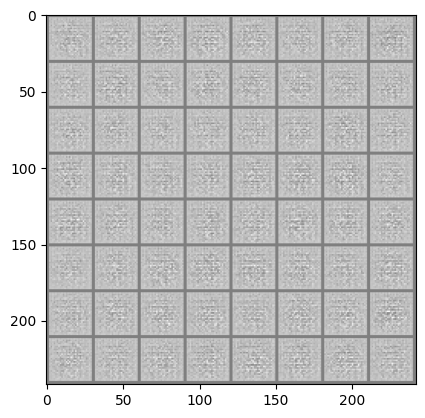

In [19]:
with torch.no_grad():
    # Note: model still in training mode
    noise = torch.randn(size=(params['batch_size'], params['noise_size'], 1, 1)).cuda()
    output = generator(noise).detach()
    print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))

# Discriminator Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [20]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels):
        super(Discriminator, self).__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Shape [14 x 14]

        self.conv_2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Shape [7 x 7]

        self.conv_3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # Shape [4 x 4]

        self.conv_4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Shape [2 x 2]

        self.output_layer = nn.Sequential(
            nn.Conv2d(512, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        return self.output_layer(x)

In [21]:
discriminator = Discriminator(params['num_channels'])
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (conv_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(nega

# Specifying Loss Function

In [22]:
adversarial_loss = nn.BCELoss()

# Plotting output after each epoch

In [23]:
# Fixed input noise
fixed_noise = torch.randn(size=(params['batch_size'], params['noise_size'], 1, 1)).cuda()
def save_output(epoch):
    plt.clf()
    with torch.no_grad():

        generator.eval()
        test_images = generator(fixed_noise)
        generator.train()

        grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
        show_grid(grid)
    wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

# Training DCGAN


*   detach()
creates a new view such that these operations are no more tracked i.e gradient is no longer being computed and subgraph is not going to be recorded.
Hence memory is not utilized.

*   loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x.

* optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
x += -lr * x.grad



0it [00:00, ?it/s]

Epoch: 1 / 80


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Tr

Discriminator Total Loss: 0.268, Generator Total Loss: 3.711


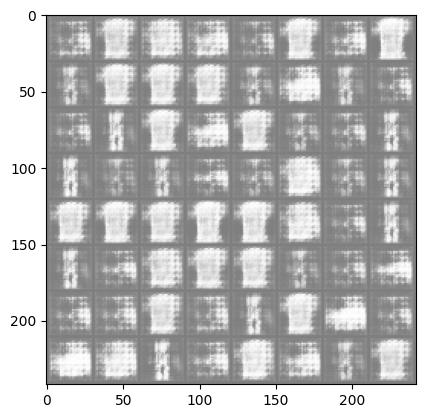

Epoch: 2 / 80
Discriminator Total Loss: 0.320, Generator Total Loss: 3.411


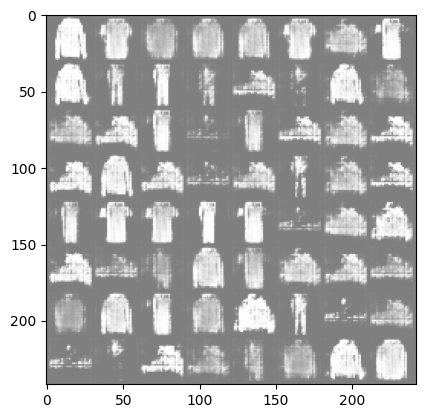

Epoch: 3 / 80
Discriminator Total Loss: 0.389, Generator Total Loss: 3.046


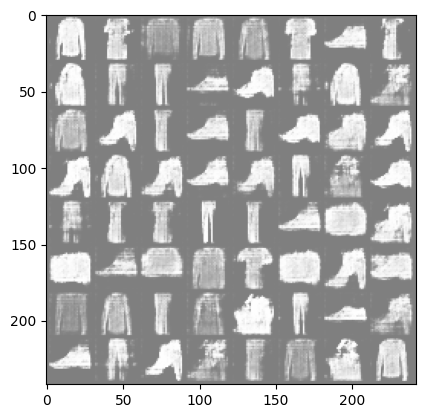

Epoch: 4 / 80
Discriminator Total Loss: 0.441, Generator Total Loss: 2.898


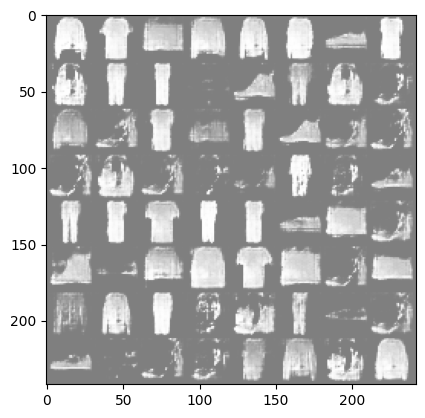

Epoch: 5 / 80
Discriminator Total Loss: 0.476, Generator Total Loss: 2.786


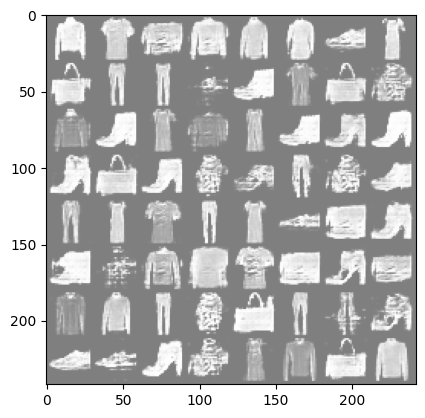

Epoch: 6 / 80
Discriminator Total Loss: 0.483, Generator Total Loss: 2.614


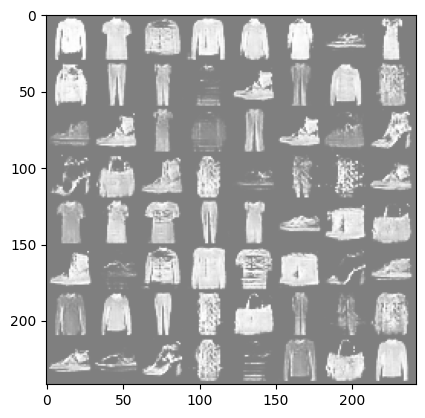

Epoch: 7 / 80
Discriminator Total Loss: 0.476, Generator Total Loss: 2.650


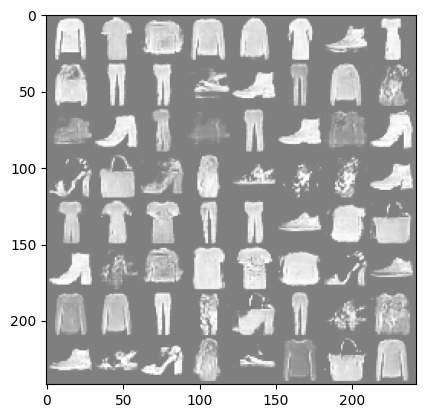

Epoch: 8 / 80
Discriminator Total Loss: 0.449, Generator Total Loss: 2.757


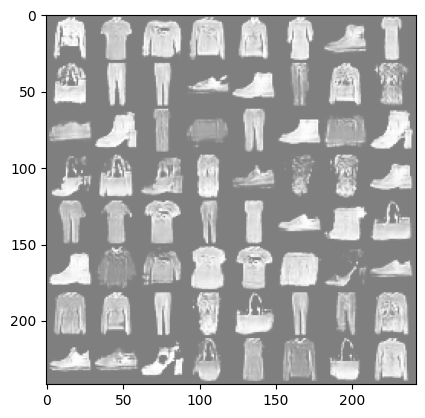

Epoch: 9 / 80
Discriminator Total Loss: 0.425, Generator Total Loss: 2.888


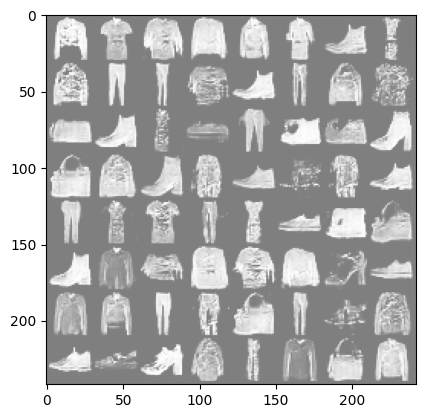

Epoch: 10 / 80
Discriminator Total Loss: 0.384, Generator Total Loss: 3.041


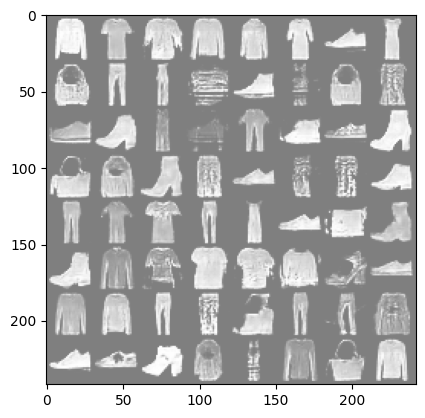

Epoch: 11 / 80
Discriminator Total Loss: 0.394, Generator Total Loss: 3.112


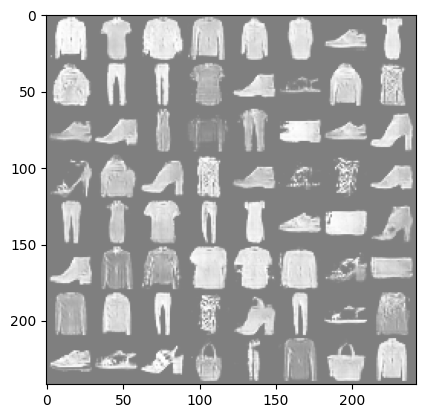

Epoch: 12 / 80
Discriminator Total Loss: 0.358, Generator Total Loss: 3.268


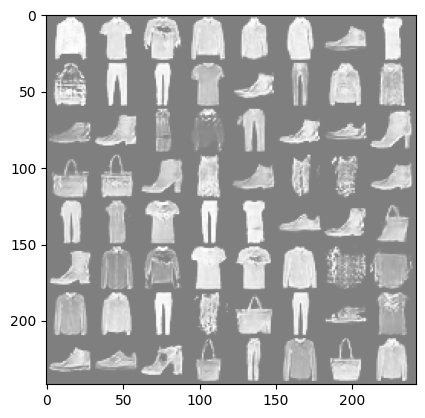

Epoch: 13 / 80
Discriminator Total Loss: 0.335, Generator Total Loss: 3.319


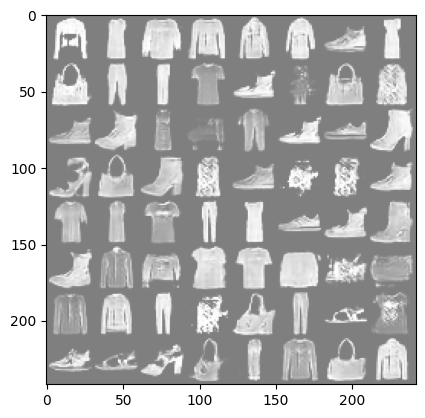

Epoch: 14 / 80
Discriminator Total Loss: 0.371, Generator Total Loss: 3.299


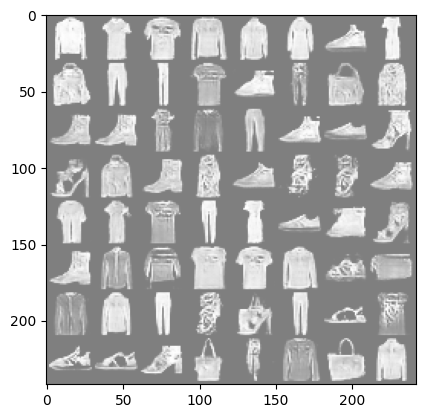

Epoch: 15 / 80
Discriminator Total Loss: 0.347, Generator Total Loss: 3.278


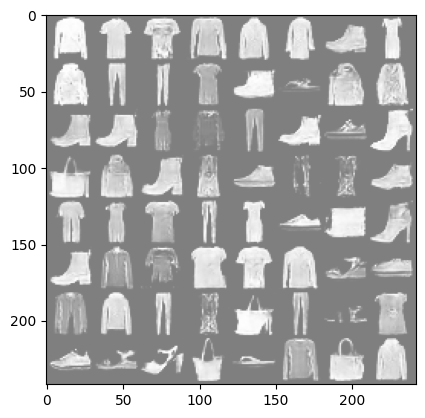

Epoch: 16 / 80
Discriminator Total Loss: 0.344, Generator Total Loss: 3.451


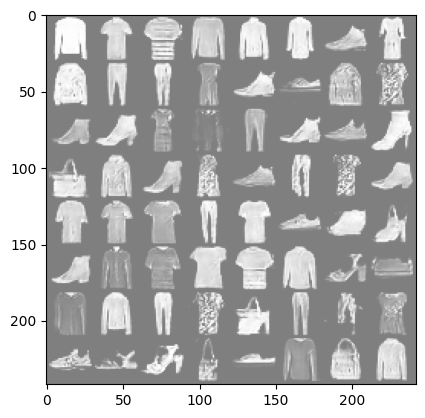

Epoch: 17 / 80
Discriminator Total Loss: 0.330, Generator Total Loss: 3.440


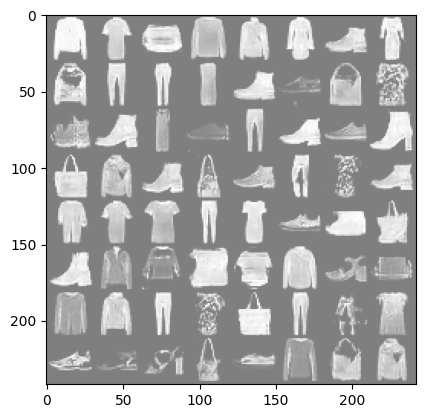

Epoch: 18 / 80
Discriminator Total Loss: 0.332, Generator Total Loss: 3.509


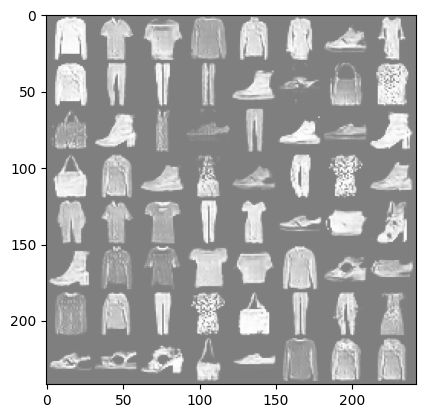

Epoch: 19 / 80
Discriminator Total Loss: 0.321, Generator Total Loss: 3.607


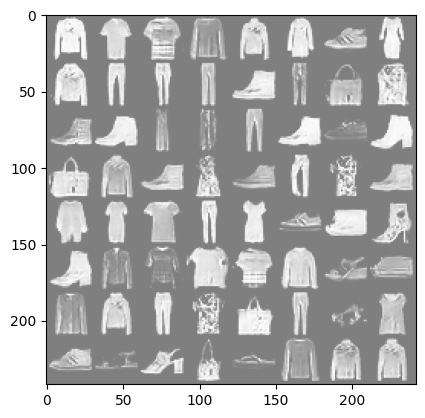

Epoch: 20 / 80
Discriminator Total Loss: 0.312, Generator Total Loss: 3.665


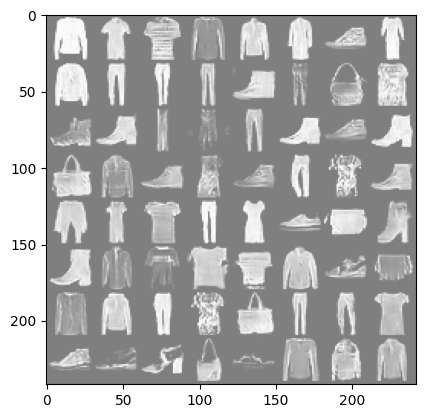

Epoch: 21 / 80
Discriminator Total Loss: 0.306, Generator Total Loss: 3.651


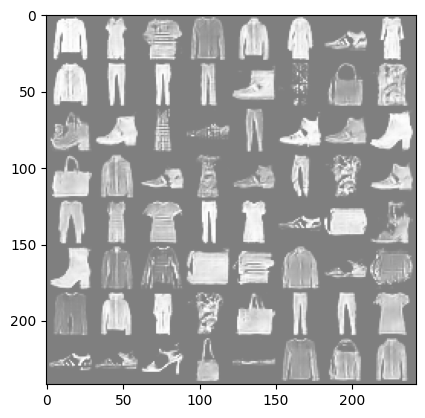

Epoch: 22 / 80
Discriminator Total Loss: 0.285, Generator Total Loss: 3.736


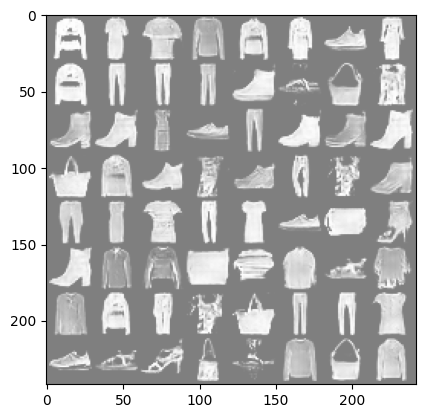

Epoch: 23 / 80
Discriminator Total Loss: 0.293, Generator Total Loss: 3.767


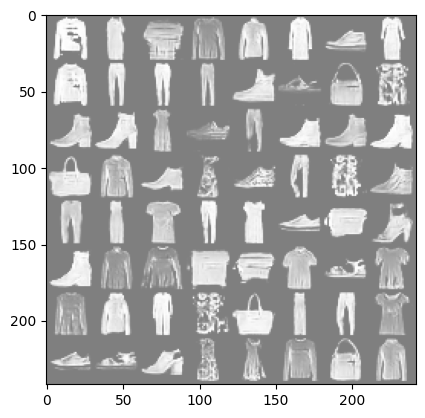

Epoch: 24 / 80
Discriminator Total Loss: 0.255, Generator Total Loss: 3.950


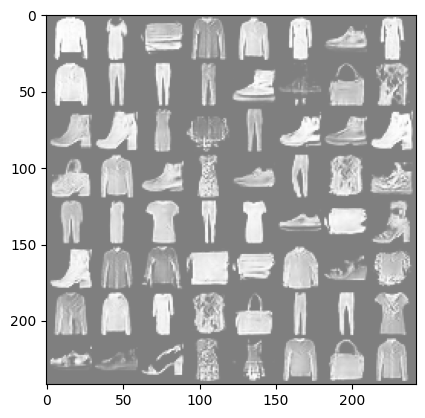

Epoch: 25 / 80
Discriminator Total Loss: 0.257, Generator Total Loss: 4.001


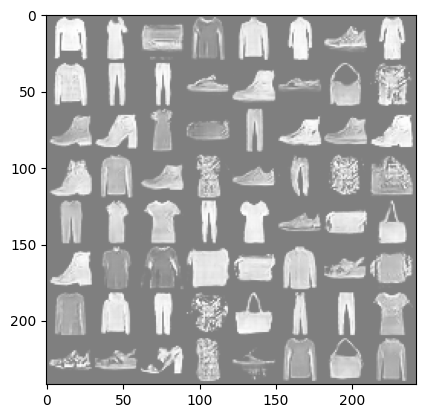

Epoch: 26 / 80
Discriminator Total Loss: 0.274, Generator Total Loss: 3.986


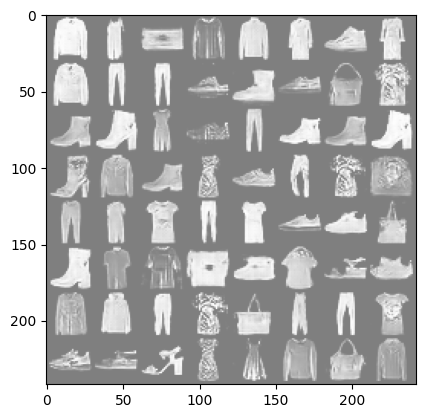

Epoch: 27 / 80
Discriminator Total Loss: 0.261, Generator Total Loss: 4.099


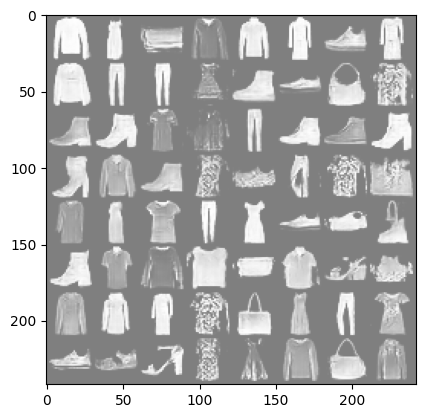

Epoch: 28 / 80
Discriminator Total Loss: 0.246, Generator Total Loss: 4.106


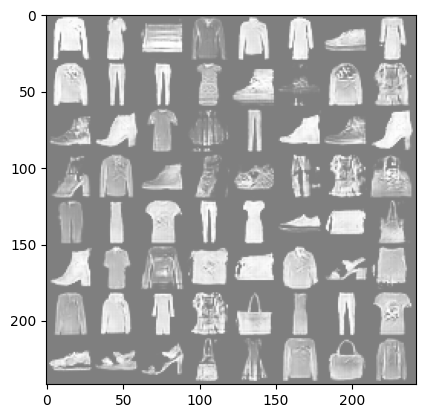

Epoch: 29 / 80
Discriminator Total Loss: 0.237, Generator Total Loss: 4.173


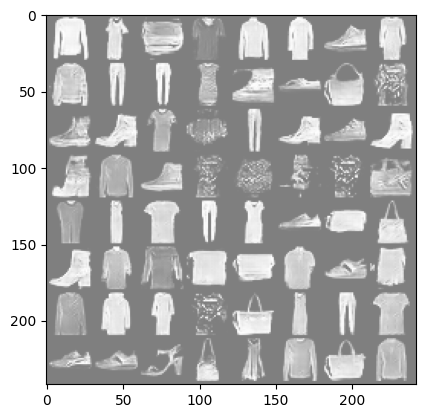

Epoch: 30 / 80
Discriminator Total Loss: 0.229, Generator Total Loss: 4.398


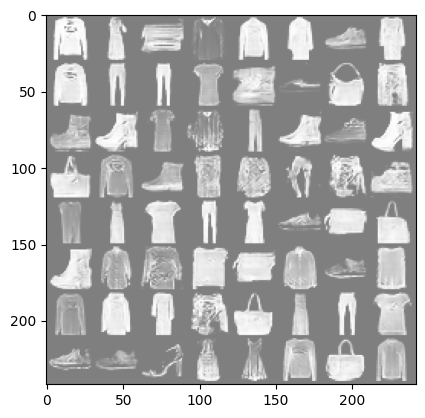

Epoch: 31 / 80


KeyboardInterrupt: 

In [24]:
# Set tdqm for epoch progress
pbar = tqdm()
images = []

wandb.watch(generator)
wandb.watch(discriminator)

for epoch in range(params['epochs']):
    print(f'Epoch: {epoch + 1} / {params["epochs"]}')
    pbar.reset(total=len(datasetloader))

    # Setting up losses
    discriminator_total_losses = []
    generator_total_losses = []

    for real_images, real_labels in datasetloader:

        # Current batch size
        current_batch_size = real_images.size()[0]

        # Convert to cuda
        real_images = real_images.cuda()
        real_labels = real_labels.type('torch.FloatTensor').cuda() # Already converted to ones earlier
        fake_labels = torch.zeros(current_batch_size, dtype=torch.float).cuda()

        # Training Generator
        generator.zero_grad()

        ## Generate fake images
        input_noise = torch.randn(size=(current_batch_size, params['noise_size'], 1, 1)).cuda()
        fake_images = generator(input_noise)

        ## Calculate Generator loss
        discriminator_fake_labels = discriminator(fake_images)

        generator_total_loss = adversarial_loss(discriminator_fake_labels.squeeze(), real_labels)
        generator_total_loss.backward()
        generator.optimizer.step()
        generator_total_losses.append(generator_total_loss)

        # Training Discriminator
        discriminator.zero_grad()

        ## Loss for real images
        discriminator_real_labels = discriminator(real_images)
        discriminator_real_loss = adversarial_loss(discriminator_real_labels.squeeze(), real_labels)

        ## Loss for fake images
        discriminator_fake_labels = discriminator(fake_images.detach())
        discriminator_fake_loss = adversarial_loss(discriminator_fake_labels.squeeze(), fake_labels)

        ## Total loss
        discriminator_total_loss = discriminator_real_loss + discriminator_fake_loss
        discriminator_total_loss.backward()
        discriminator.optimizer.step()
        discriminator_total_losses.append(discriminator_total_loss)

        # Update tqdm
        pbar.update()

    print('Discriminator Total Loss: {:.3f}, Generator Total Loss: {:.3f}'.format(
            torch.mean(torch.FloatTensor(discriminator_total_losses)),
            torch.mean(torch.FloatTensor(generator_total_losses))
        ))

    wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_total_losses)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_total_losses))},  step=epoch + 1)
    if (epoch + 1) % params['output_after_every_n_epochs'] == 0:
        save_output(epoch + 1)

pbar.refresh()

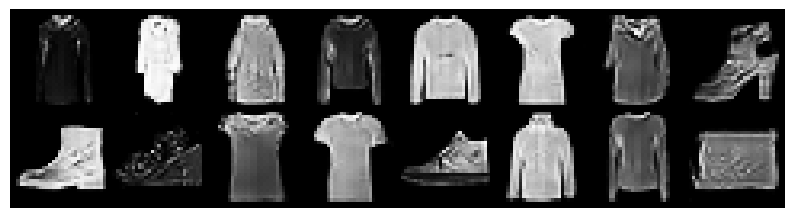

In [25]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming the generator is defined and trained
# Make sure the generator is set to evaluation mode
generator.eval()

# Create a DataLoader for the test set
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=params['batch_size'], shuffle=False)

# Function to generate and show images
def generate_and_show(generator, noise_size, num_images=16):
    # Generate random noise
    noise = torch.randn(num_images, noise_size, 1, 1).cuda()

    # Generate images from noise
    with torch.no_grad():
        fake_images = generator(noise).cpu()

    # Display the generated images
    grid = torchvision.utils.make_grid(fake_images, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Generate and show images
generate_and_show(generator, params['noise_size'])

# Optionally, you can save the generated images
torchvision.utils.save_image(fake_images, 'generated_images.png', normalize=True)
